## Import the libraries

In [1]:
import os
import pickle
import pandas as pd
from tqdm.notebook import tqdm
import random
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv

from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions

from ta.momentum import StochasticOscillator
from ta.momentum import RSIIndicator

import torch

2023-12-06 04:09:56.196992: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 04:09:56.304367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 04:09:56.987769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Processing

In [2]:
df = pd.read_csv("AAPL.csv")

# Calculate Stochastic Momentum Index (SMI)
stoch = StochasticOscillator(close=df['Close'], high=df['High'], low=df['Low'], window=14, smooth_window=3)
df['smi'] = stoch.stoch_signal()

# Calculate Relative Strength Index (RSI)
rsi = RSIIndicator(df['Close'], window=14)
df['rsi'] = rsi.rsi()

# Drop rows with any NaN values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#Set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#Bucket the data

# Bucket the 'rsi' column into 10 equally sized buckets and return the bins
rsi_buckets, rsi_bins = pd.qcut(df['rsi'], q=10, retbins=True, labels=False)

# Bucket the 'smi' column into 10 equally sized buckets and return the bins
smi_buckets, smi_bins = pd.qcut(df['smi'], q=10, retbins=True, labels=False)

# Print the resulting bins and their ranges
print("RSI Bins and Ranges:")
for i, bin_range in enumerate(zip(rsi_bins[:-1], rsi_bins[1:])):
    print(f"Bucket {i + 1}: Range {bin_range}")

print("\nSMI Bins and Ranges:")
for i, bin_range in enumerate(zip(smi_bins[:-1], smi_bins[1:])):
    print(f"Bucket {i + 1}: Range {bin_range}")

# Bucket the 'rsi' column into 10 equally sized buckets and add the 'rsi_bucket' column
df['rsi_bucket'] = pd.qcut(df['rsi'], q=10, labels=False)

# Bucket the 'smi' column into 10 equally sized buckets and add the 'smi_bucket' column
df['smi_bucket'] = pd.qcut(df['smi'], q=10, labels=False)

RSI Bins and Ranges:
Bucket 1: Range (15.346105137617542, 36.17501741472005)
Bucket 2: Range (36.17501741472005, 41.3929950065132)
Bucket 3: Range (41.3929950065132, 45.55124102027758)
Bucket 4: Range (45.55124102027758, 49.4340140122531)
Bucket 5: Range (49.4340140122531, 52.955338750071434)
Bucket 6: Range (52.955338750071434, 56.59396681174043)
Bucket 7: Range (56.59396681174043, 60.59911929194563)
Bucket 8: Range (60.59911929194563, 64.82529374075921)
Bucket 9: Range (64.82529374075921, 70.21974960069998)
Bucket 10: Range (70.21974960069998, 91.50256204861311)

SMI Bins and Ranges:
Bucket 1: Range (0.0, 13.330565048089818)
Bucket 2: Range (13.330565048089818, 22.67725092908801)
Bucket 3: Range (22.67725092908801, 33.65529152006455)
Bucket 4: Range (33.65529152006455, 45.68693996762808)
Bucket 5: Range (45.68693996762808, 57.875260055709475)
Bucket 6: Range (57.875260055709475, 69.04859287560879)
Bucket 7: Range (69.04859287560879, 78.01723512670729)
Bucket 8: Range (78.017235126707

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,smi,rsi,rsi_bucket,smi_bucket
Date,,,,,,,,,,
1981-01-06,0.144531,0.144531,0.143973,0.143973,0.111410,45158400,75.862874,56.111860,5,6
1981-01-07,0.138393,0.138393,0.137835,0.137835,0.106660,55686400,63.770629,49.591320,4,5
1981-01-08,0.135603,0.135603,0.135045,0.135045,0.104501,39827200,50.436024,46.922193,3,4
1981-01-09,0.142299,0.142857,0.142299,0.142299,0.110114,21504000,44.324028,53.873578,5,3
1981-01-12,0.142299,0.142299,0.141183,0.141183,0.109251,23699200,38.320327,52.729429,4,3


## Create Train-Test Split

In [4]:
training_start_date = pd.to_datetime("2010-11-10")
training_end_date = pd.to_datetime("2022-11-10")

testing_start_date = pd.to_datetime("2022-11-11")
testing_end_date = pd.to_datetime("2023-11-10")

df = df[(df.index >= training_start_date) & (df.index <= testing_end_date)]
test_df = df[(df.index > testing_start_date) & (df.index <= testing_end_date)].copy()

df.shape

(3273, 10)

In [5]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume,smi,rsi,rsi_bucket,smi_bucket
Date,,,,,,,,,,
2022-11-14,148.970001,150.279999,147.429993,148.279999,147.455780,73374100,60.135503,52.974812,5,5
2022-11-15,152.220001,153.589996,148.559998,150.039993,149.206009,89868300,64.705859,54.734903,5,5
2022-11-16,149.130005,149.869995,147.289993,148.789993,147.962936,64218300,63.393857,53.211572,5,5
2022-11-17,146.429993,151.479996,146.149994,150.720001,149.882233,80389400,69.203836,55.281025,5,6
2022-11-18,152.309998,152.699997,149.970001,151.289993,150.449051,74829600,73.378081,55.901374,5,6


In [6]:
test_df.tail()

,Open,High,Low,Close,Adj Close,Volume,smi,rsi,rsi_bucket,smi_bucket
Date,,,,,,,,,,
2023-11-06,176.380005,179.429993,176.210007,179.229996,178.994186,63841300,91.134645,59.164606,6,8
2023-11-07,179.179993,182.440002,178.970001,181.820007,181.580780,70530000,93.655700,63.205255,7,9
2023-11-08,182.350006,183.449997,181.589996,182.889999,182.649368,49340300,97.233297,64.756762,7,9
2023-11-09,182.960007,184.119995,181.809998,182.410004,182.169998,53763500,94.628371,63.463948,7,9
2023-11-10,183.970001,186.570007,183.529999,186.399994,186.399994,66133400,95.589567,69.003593,8,9


In [7]:
# print("----- Training Env Information -----")
# print("shape                :", train_env.unwrapped.shape)
# print("df.shape             :", train_env.unwrapped.df.shape)
# print("prices.shape         :", train_env.unwrapped.prices.shape)
# print("signal_features.shape:", train_env.unwrapped.signal_features.shape)
# print("max_possible_profit  :", train_env.unwrapped.max_possible_profit())
# print("action_space.shape   :", train_env.unwrapped.action_space)
# print()
# print("----- Testing Env Information -----")
# print("shape                :", test_env.unwrapped.shape)
# print("df.shape             :", test_env.unwrapped.df.shape)
# print("prices.shape         :", test_env.unwrapped.prices.shape)
# print("signal_features.shape:", test_env.unwrapped.signal_features.shape)
# print("max_possible_profit  :", test_env.unwrapped.max_possible_profit())
# print("action_space.shape   :", test_env.unwrapped.action_space)

## Setup the Environment

In [8]:
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Adj Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['smi_bucket', 'rsi_bucket']].to_numpy()[start:end]
    return prices, signal_features

class MyStockEnv(StocksEnv):
    _process_data = my_process_data

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Override the variables
        self.trade_fee_bid_percent = 0.001
        self.trade_fee_ask_percent = 0.001

## Train the Models

In [9]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min_ = np.min(reward_over_episodes)
    max_ = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min_:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max_:>10.3f}')

    return min_, avg, max_


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, train_env, test_env, seed, ws, label_name, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = train_env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f"Model : {re.match(r'[a-zA-Z0-9]+', str(type(model)).split('.')[-1]).group(0)}")
        print(f"Policy: {re.match(r'[a-zA-Z0-9]+', str(type(model.policy)).split('.')[-1]).group(0)}")

        path = f"window{ws}/{label_name}.zip"
        if os.path.exists(path):
            model = model.load(path, test_env)
        else:
            model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
            model.save(path)
        
        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    total_info = []
        
    if vec_env: 
        obs = vec_env.reset()
    else:
        obs, info = test_env.reset()

    total_reward = 0
    done = False

    while not done:
        if model is not None:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = vec_env.step(action)
        else: # random
            action = test_env.action_space.sample()
            obs, reward, terminated, truncated, info = test_env.step(action)
            done = terminated or truncated

        total_reward += reward
        total_info.append(info)
        if done:
            break
    
    try:
        if len(total_reward) == 1:
            total_reward = total_reward[0]
    except:
        pass

    return total_reward, total_info

In [13]:
with open("all_info.p", "rb") as f:
    all_info = pickle.load(f)

with open("plot_settings.p", "rb") as f:
    plot_settings = pickle.load(f)

with open("plot_data.p", "rb") as f:
    plot_data = pickle.load(f)

In [10]:
window_sizes = [1, 5, 10]
_plot_settings = {}
_plot_data = {}
_all_info = {}

for window_size in window_sizes:
    print(f"---------- Window Size: {window_size} ----------")

    train_frame_bound = (window_size, df.shape[0] - test_df.shape[0])
    test_frame_bound = (df.shape[0] - test_df.shape[0], df.shape[0])

    # Create the training and testing environment
    train_env = MyStockEnv(df=df, window_size=window_size, frame_bound=train_frame_bound)
    test_env = MyStockEnv(df=df, window_size=window_size, frame_bound=test_frame_bound)

    plot_settings = {}
    plot_data = {}
    all_info = {}
    
    seed = 42  # random seed

    # Random actions
    model = None 
    total_learning_timesteps = 0
    rewards, info = train_test_model(model, train_env, test_env, seed, window_size, "Random actions", total_learning_timesteps)

    min_, avg, max_ = print_stats(rewards)
    class_name = f'Random actions'
    label = f'Avg. {avg:>7.2f} : {class_name}'

    plot_data['rnd_rewards'] = rewards
    plot_settings['rnd_rewards'] = {'label': label}
    all_info[class_name] = info

    learning_timesteps_list_in_K = [25, 50, 100, 250, 300, 500]
    model_class_list = [DQN, A2C]

    for timesteps in learning_timesteps_list_in_K:
                
        total_learning_timesteps = timesteps * 1000
        step_key = f'{timesteps}K'

        for model_class in model_class_list:
            policy_dict = model_class.policy_aliases

            # MlpPolicy or MlpLstmPolicy
            policy = policy_dict.get('MlpPolicy')
            if policy is None:
                policy = policy_dict.get('MlpLstmPolicy')

            model = model_class(policy, train_env, verbose=0)

            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_{step_key}'
            if plot_key in plot_data:
                continue

            rewards, info = train_test_model(model, train_env, test_env, seed, window_size,
                                             plot_key, total_learning_timesteps)

            label = f'Avg. {rewards:>7.2f} : {class_name} - {step_key}'

            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}
            all_info[plot_key] = info
            
            _plot_data[window_size] = plot_data
            _plot_settings[window_size] = plot_settings
            _all_info[window_size] = all_info
            
            with open("plot_data.p", "wb") as f:
                pickle.dump(_plot_data, f)
            
            with open("plot_settings.p", "wb") as f:
                pickle.dump(_plot_settings, f)
            
            with open("all_info.p", "wb") as f:
                pickle.dump(_all_info, f)

---------- Window Size: 1 ----------
--------------------------------------------------------------------------------
RANDOM actions
Min. Reward          :     24.199
Avg. Reward          :     24.199
Max. Reward          :     24.199
--------------------------------------------------------------------------------
Model : DQN
Policy: DQNPolicy
--------------------------------------------------------------------------------
Model : A2C
Policy: ActorCriticPolicy
--------------------------------------------------------------------------------
Model : DQN
Policy: DQNPolicy
--------------------------------------------------------------------------------
Model : A2C
Policy: ActorCriticPolicy
--------------------------------------------------------------------------------
Model : DQN
Policy: DQNPolicy
--------------------------------------------------------------------------------
Model : A2C
Policy: ActorCriticPolicy
---------------------------------------------------------------------------

In [17]:
# with open(f"window{window_size}/all_info{window_size}.p", "wb") as f:
#     pickle.dump(all_info, f)

# with open(f"window{window_size}/plot_settings{window_size}.p", "wb") as f:
#     pickle.dump(plot_settings, f)

# with open(f"window{window_size}/plot_data{window_size}.p", "wb") as f:
#     pickle.dump(plot_data, f)

## Visualize the Results

In [14]:
data = []

# Iterate through the nested dictionary
for window_size, rewards in plot_data.items():
    for key, value in rewards.items():
        # Split the key to extract model and episode
        parts = key.split('_')
        if len(parts) == 3:
            model, _, episode = parts
        else:
            model = 'Random'
            episode = '0'
        # Append the data to the list
        data.append({'window_size': f"{model}: window_size = {window_size}", 'model': model,
                     'episodes': int(int(episode.strip('K')) * 1000 / 3023), 'reward': value})

# Create a DataFrame
data = pd.DataFrame(data)
data = data.drop_duplicates(subset=["model", "episodes", "reward"])
data = data.reset_index(drop=True)
data

,window_size,model,episodes,reward
0,Random: window_size = 1,Random,0,24.198714
1,DQN: window_size = 1,DQN,8,9.537866
2,A2C: window_size = 1,A2C,8,16.593628
3,DQN: window_size = 1,DQN,16,9.537866
4,A2C: window_size = 1,A2C,16,13.182005
5,DQN: window_size = 1,DQN,33,16.512327
6,A2C: window_size = 1,A2C,33,31.359970
7,DQN: window_size = 1,DQN,82,24.307510
8,A2C: window_size = 1,A2C,82,28.824326
9,DQN: window_size = 1,DQN,99,27.707993


In [15]:
sns.set_style("whitegrid")

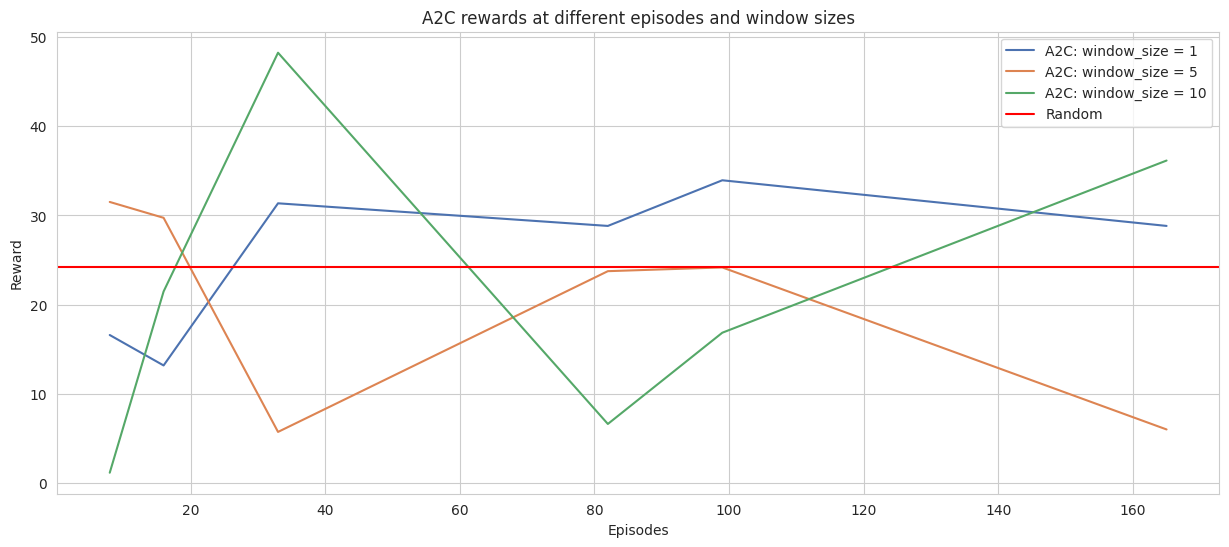

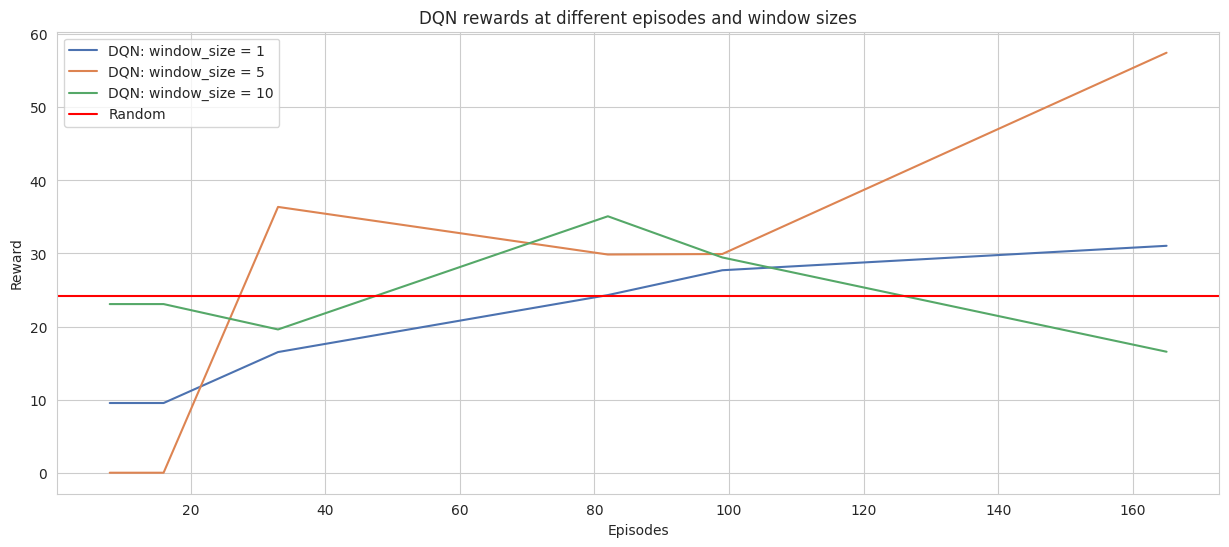

In [16]:
for m in ["A2C", "DQN"]:
    plt.figure(figsize=(15, 6))
    r = data[data.model == "Random"].reward.values[0]
    ax = sns.lineplot(data=data[data.model == m], x='episodes', y='reward', hue="window_size", palette="deep")
    ax.axhline(y=r, label="Random", color="red",
               xmin=data.episodes.min(), xmax=data.episodes.max())

    plt.title(f'{m} rewards at different episodes and window sizes')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

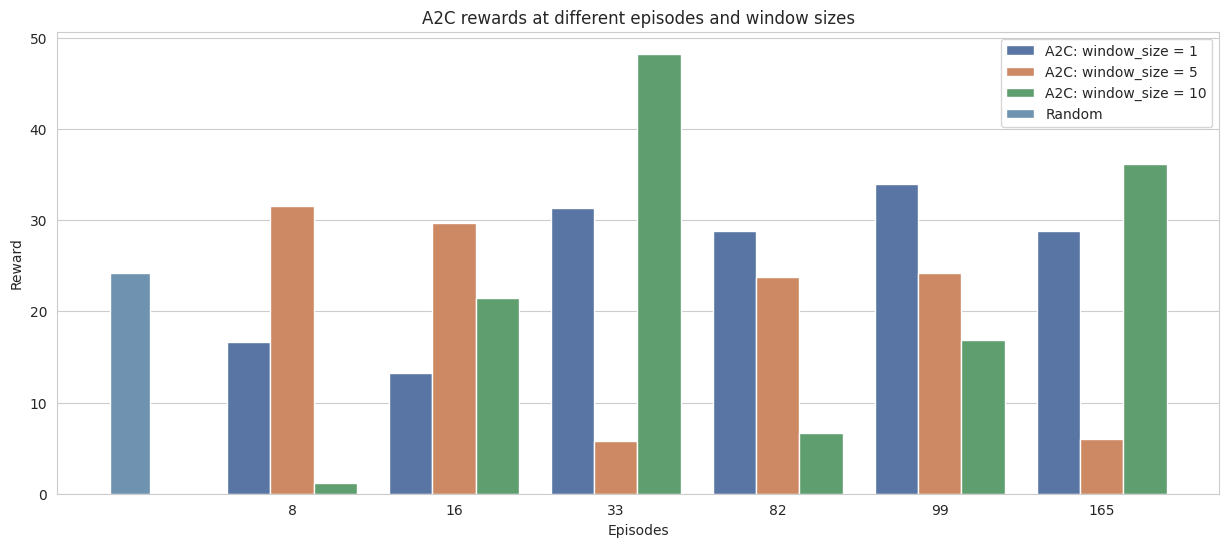

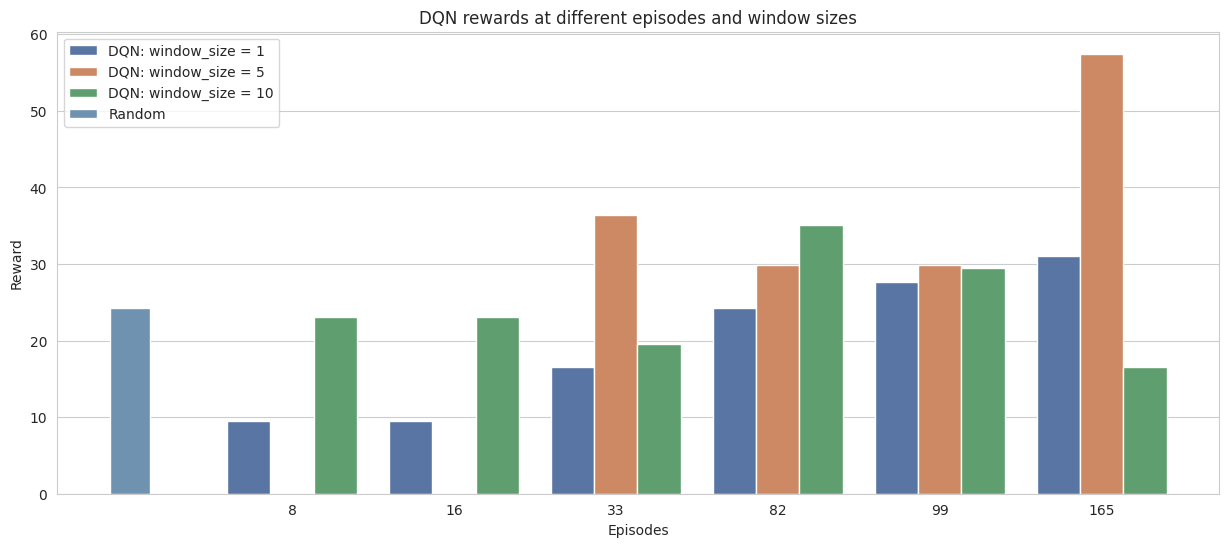

In [17]:
for m in ["A2C", "DQN"]:
    plt.figure(figsize=(15, 6))
    r = data[data.model == "Random"].reward.values[0]
    ax = sns.barplot(data=data[data.model == m], x='episodes', y='reward', hue="window_size", palette="deep")
    ax.bar(height=data[data.model == "Random"].reward.values[0:1], x=[-1], label="Random", color='#6E92B0', width=0.25)

    plt.title(f'{m} rewards at different episodes and window sizes')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

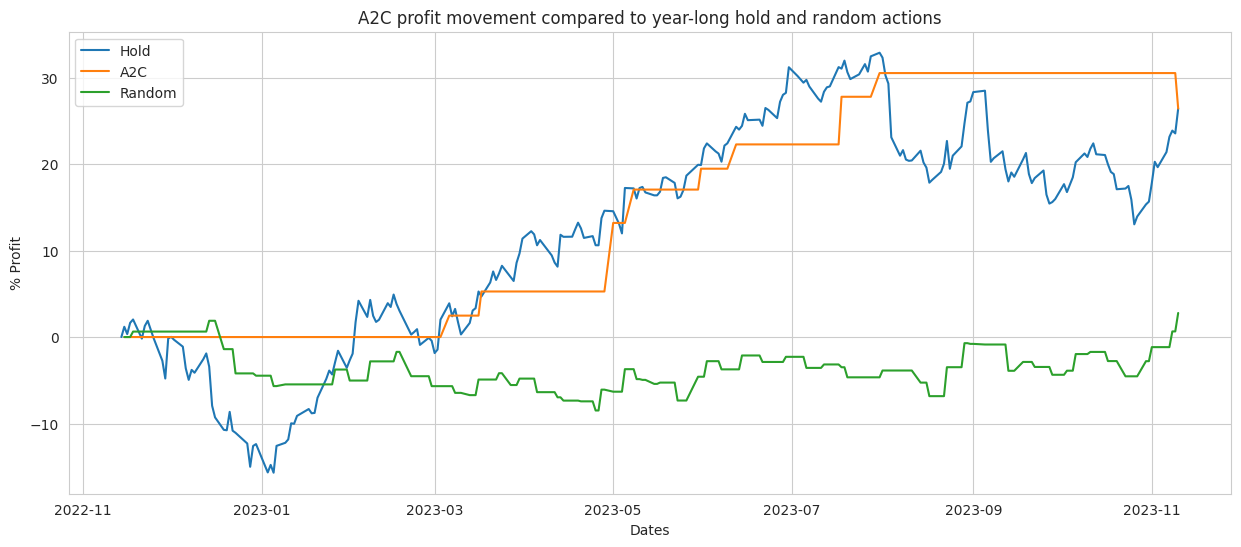

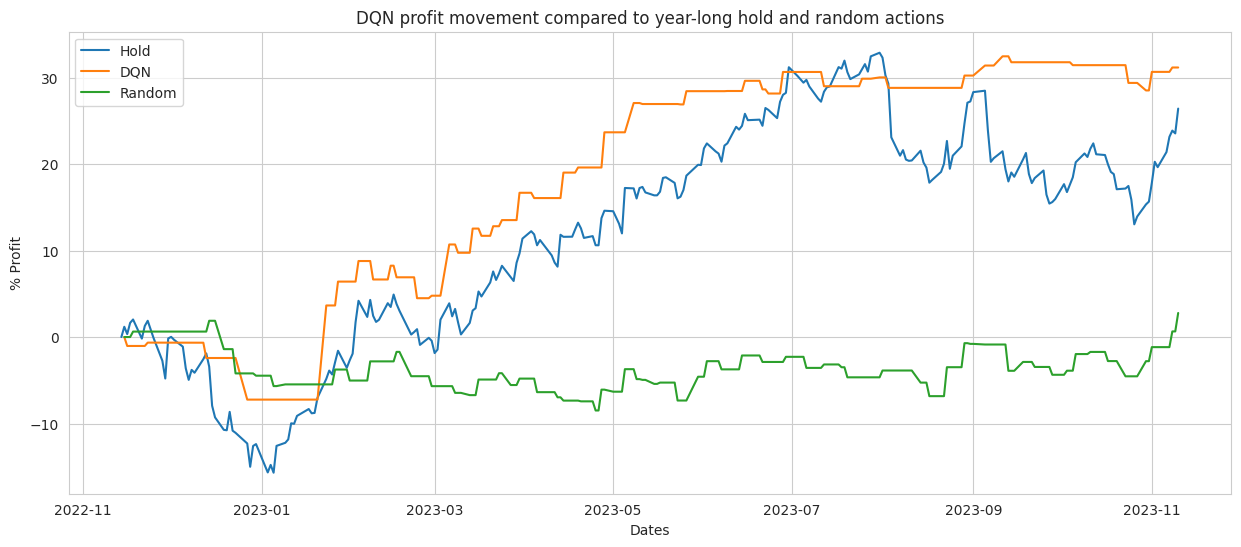

In [47]:
initial_p = test_df["Adj Close"][0]
hold_profit = []
for i in range(len(test_df)):
    p = (test_df["Adj Close"][i] - initial_p) * 100 / initial_p
    hold_profit.append(p)

random_profit = [(x['total_profit'] - 1) * 100 for x in all_info[1]["Random actions"]]

key_map = {"A2C": (10, "A2C_rewards_100K"), "DQN": (5, "DQN_rewards_500K")}
for m in ["A2C", "DQN"]:
    k, v = key_map[m]
    rl_profit = all_info[k][v]
    rl_profit = [(x[0]['total_profit'] - 1) * 100 for x in rl_profit]
    
    plt.figure(figsize=(15, 6))
    sns.lineplot(x=test_df.index, y=hold_profit, label="Hold")
    sns.lineplot(x=test_df.index[1:], y=rl_profit, label=m)
    sns.lineplot(x=test_df.index[1:], y=random_profit, label="Random")

    plt.title(f'{m} profit movement compared to year-long hold and random actions')
    plt.xlabel('Dates')
    plt.ylabel('% Profit')
    plt.legend()
    plt.show()

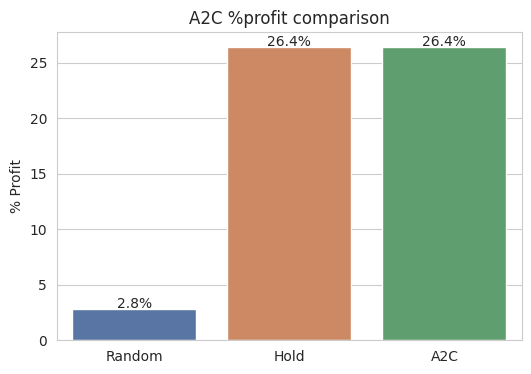

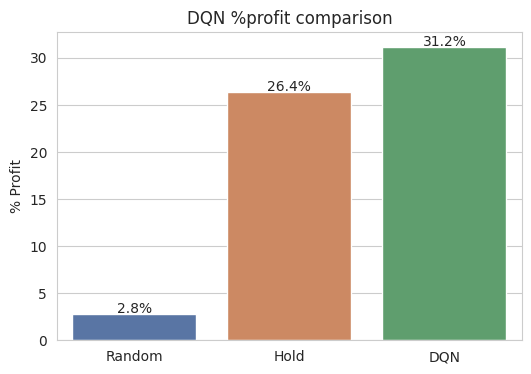

In [45]:
for m in ["A2C", "DQN"]:
    
    k, v = key_map[m]
    rl_profit = all_info[k][v]
    rl_profit = (rl_profit[-1][0]['total_profit'] - 1) * 100
    
    plt.figure(figsize=(6, 4))
    ps = [random_profit[-1], hold_profit[-1], rl_profit]
    xs = ["Random", "Hold", m]
    ax = sns.barplot(y=ps, x=xs, palette="deep")
#     for i in ax.containers:
#         ax.bar_label(f"{round(i, 2)}%",)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 0.1, f"{round(height, 1)}%", ha="center")

    plt.title(f'{m} %profit comparison')
    plt.xlabel('')
    plt.ylabel('% Profit')
    plt.show()